# Importing libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Loading the data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Skimming through the data

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1888 entries, 0 to 1887
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   campaign_id         1888 non-null   int64  
 1   sender              1888 non-null   int64  
 2   subject_len         1888 non-null   int64  
 3   body_len            1888 non-null   int64  
 4   mean_paragraph_len  1888 non-null   int64  
 5   day_of_week         1888 non-null   int64  
 6   is_weekend          1888 non-null   int64  
 7   times_of_day        1888 non-null   object 
 8   category            1888 non-null   int64  
 9   product             1888 non-null   int64  
 10  no_of_CTA           1888 non-null   int64  
 11  mean_CTA_len        1888 non-null   int64  
 12  is_image            1888 non-null   int64  
 13  is_personalised     1888 non-null   int64  
 14  is_quote            1888 non-null   int64  
 15  is_timer            1888 non-null   int64  
 16  is_emo

In [4]:
train.isna().sum()

campaign_id           0
sender                0
subject_len           0
body_len              0
mean_paragraph_len    0
day_of_week           0
is_weekend            0
times_of_day          0
category              0
product               0
no_of_CTA             0
mean_CTA_len          0
is_image              0
is_personalised       0
is_quote              0
is_timer              0
is_emoticons          0
is_discount           0
is_price              0
is_urgency            0
target_audience       0
click_rate            0
dtype: int64

- No missing values in the training dataset

In [5]:
train[train.duplicated()]

,campaign_id,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,...,is_image,is_personalised,is_quote,is_timer,is_emoticons,is_discount,is_price,is_urgency,target_audience,click_rate


- No rows in the training dataset are duplicated

In [6]:
target_column = 'click_rate'
feature_columns = ['campaign_id', 'sender', 'subject_len', 'body_len',
       'mean_paragraph_len', 'day_of_week', 'is_weekend', 'times_of_day',
       'category', 'product', 'no_of_CTA', 'mean_CTA_len', 'is_image',
       'is_personalised', 'is_quote', 'is_timer', 'is_emoticons',
       'is_discount', 'is_price', 'is_urgency', 'target_audience']

releavnt_features = [feature_column for feature_column in feature_columns if feature_column != 'campaign_id']

- As 'campaign_id' is a unique identifier, therefore dropping it

In [7]:
sorted(train['is_timer'].unique().tolist())

[0]

- Will drop 'is_timer' column as the value is always 0

In [8]:
train['is_price'].value_counts()

0        1875
5499        5
8000        2
5000        2
4999        1
1399        1
1000        1
14999       1
Name: is_price, dtype: int64

In [9]:
def clean_value(value):
    if value != 0:
        return 1
    return 0

In [67]:
train['sender'] = train['sender'].map(train['sender'].value_counts().to_dict())
train['times_of_day'] = train['times_of_day'].replace({'Morning': 0, 'Noon':1, 'Evening': 2})
train['is_image'] = train['is_image'].map(train['is_image'].value_counts().to_dict())
train['is_emoticons'] = train['is_emoticons'].map(train['is_emoticons'].value_counts().to_dict())
train['is_price'] = train['is_price'].apply(clean_value)

In [68]:
test['sender'] = test['sender'].map(test['sender'].value_counts().to_dict())
test['times_of_day'] = test['times_of_day'].replace({'Morning': 0, 'Noon':1, 'Evening': 2})
test['is_image'] = test['is_image'].map(test['is_image'].value_counts().to_dict())
test['is_emoticons'] = test['is_emoticons'].map(test['is_emoticons'].value_counts().to_dict())
test['is_price'] = test['is_price'].apply(clean_value)

In [69]:
category_features = ['sender', 'day_of_week', 'times_of_day', 'category', 'product', 
    'is_image', 'is_personalised', 'is_quote', 'is_emoticons', 'is_urgency', 'target_audience']
continous_features = ['subject_len', 'body_len', 'mean_paragraph_len', 'no_of_CTA',  'mean_CTA_len', 'is_price']
dropped_columns = ['campaign_id', 'is_timer']

# Exploratory data analysis

In [70]:
df = train.drop(dropped_columns, axis=1)
df2 = test.drop(dropped_columns, axis=1)

## Correlation heatmap between the target and feature columns

<AxesSubplot:>

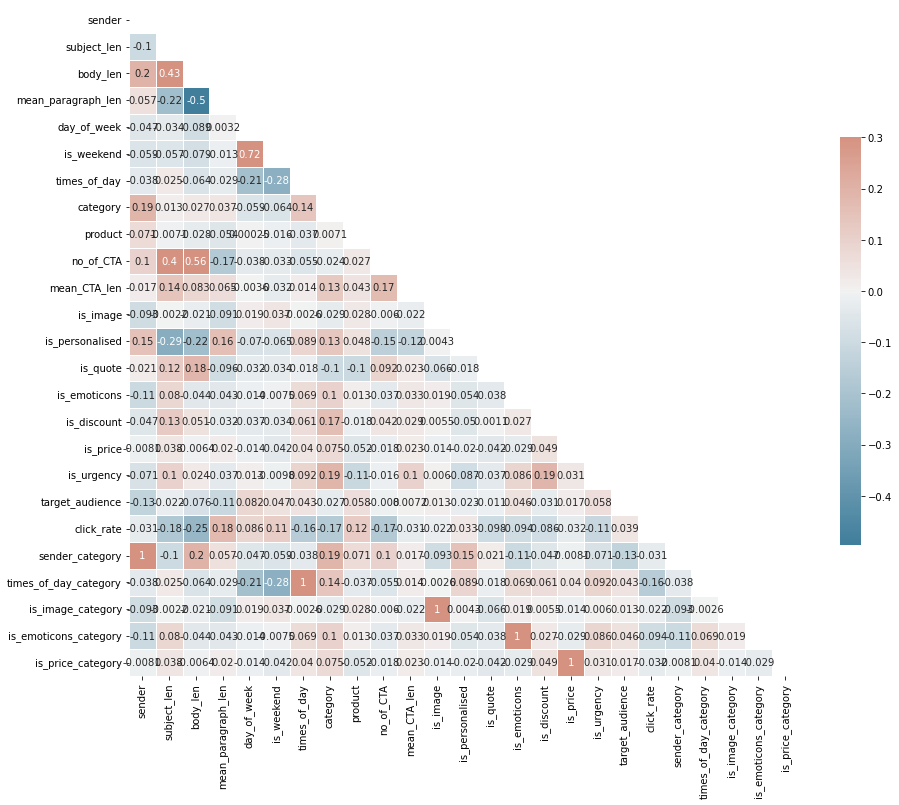

In [17]:
corelartion = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corelartion, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corelartion, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

- click through rate shows correlation with mean_paragraph_len and category 

## Impact of categorical features on click-through rate

### 1, 2, 6, 9, 10, 11, 14 category have very low click-through rates

<AxesSubplot:xlabel='category', ylabel='click_rate'>

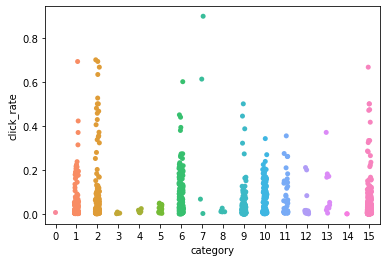

In [18]:
sns.stripplot(y = target_column, x = 'category', data = df)

### Some products have high click through rate while large number is having low click through rate

<AxesSubplot:xlabel='product', ylabel='click_rate'>

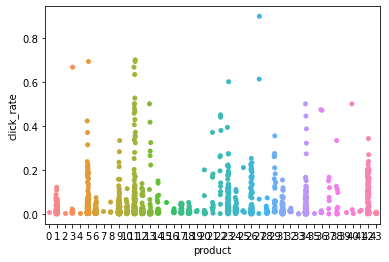

In [19]:
sns.stripplot(y = target_column, x = 'product', data = df)

### 0 class i.e. not personalised emails have high click through rate

<AxesSubplot:xlabel='is_personalised', ylabel='click_rate'>

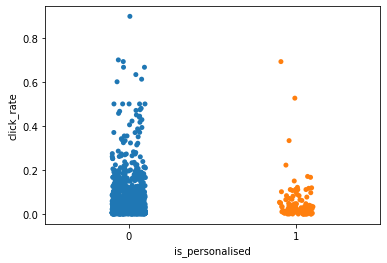

In [20]:
sns.stripplot(y = target_column, x = 'is_personalised', data = df)

### lower number of quotes have higher click through rate. A sharp decline in click-throigh rate is observed after 3 number of quotes

<AxesSubplot:xlabel='is_quote', ylabel='click_rate'>

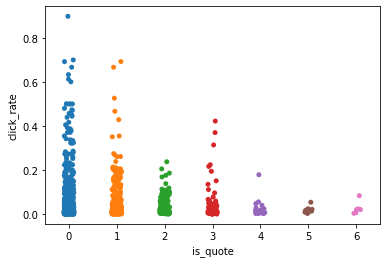

In [21]:
sns.stripplot(y = target_column, x = 'is_quote', data = df)

### emails without discount have high-click through rates

<AxesSubplot:xlabel='is_discount', ylabel='click_rate'>

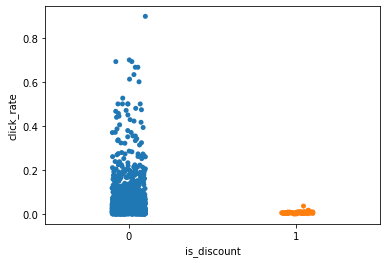

In [22]:
sns.stripplot(y = target_column, x = 'is_discount', data = df)

### emails containing urgency have higher-clickthrough rates

<AxesSubplot:xlabel='is_urgency', ylabel='click_rate'>

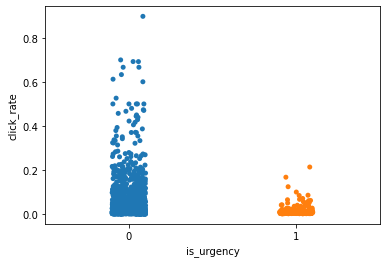

In [23]:
sns.stripplot(y = target_column, x = 'is_urgency', data = df)

### emails to target_audience with cluster label of 0, 11, 13, 15, 16 have low-clickthrough rates

<AxesSubplot:xlabel='target_audience', ylabel='click_rate'>

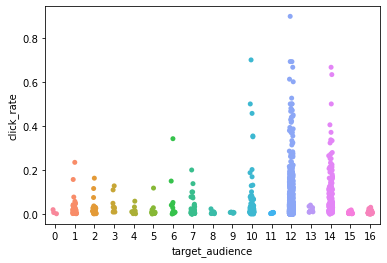

In [24]:
sns.stripplot(y = target_column, x = 'target_audience', data = df)

### rmails sent on weekdays have click-through rate than weekend

<AxesSubplot:xlabel='is_weekend', ylabel='click_rate'>

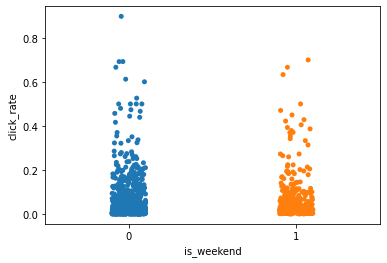

In [25]:
sns.stripplot(y = target_column, x = 'is_weekend', data = df)

### emails sent on 0th  and 6th day of week have least click through rate 

<AxesSubplot:xlabel='day_of_week', ylabel='click_rate'>

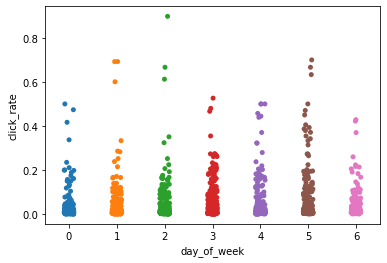

In [26]:
sns.stripplot(y = target_column, x = 'day_of_week', data = df)

### emails with sender 3, 10 and 15 have higher click through rates. Others have very low click through rates 

<AxesSubplot:xlabel='sender', ylabel='click_rate'>

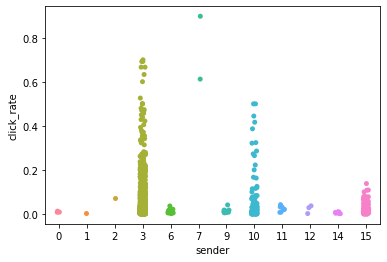

In [27]:
sns.stripplot(y = target_column, x = 'sender', data = df)

### emails sent in the mornings have lower click through rates

<AxesSubplot:xlabel='times_of_day', ylabel='click_rate'>

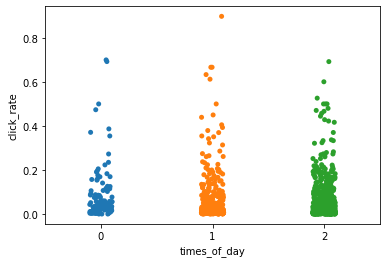

In [28]:
sns.stripplot(y = target_column, x = 'times_of_day', data = df)

### emails with lower image have higher click through rate. A sharp decline is seen after 3 images in an email.

<AxesSubplot:xlabel='is_image', ylabel='click_rate'>

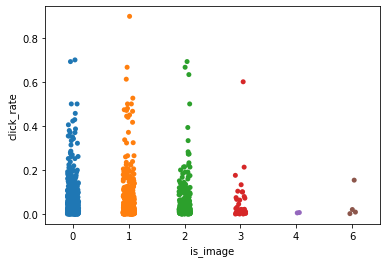

In [29]:
sns.stripplot(y = target_column, x = 'is_image', data = df)

### emails with one emoticons have higher click through rates

<AxesSubplot:xlabel='is_emoticons', ylabel='click_rate'>

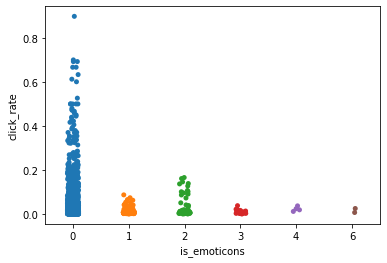

In [30]:
sns.stripplot(y = target_column, x = 'is_emoticons', data = df)

### emails without price information have higher click through rate

<AxesSubplot:xlabel='is_price', ylabel='click_rate'>

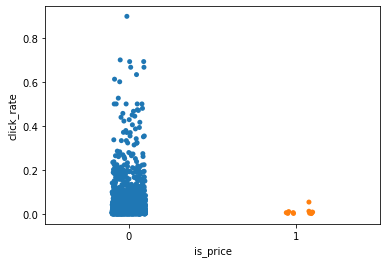

In [31]:
sns.stripplot(y = target_column, x = 'is_price', data = df)

### Impact of continous variable on click through rate

### emails with subject length 50 to 100 have high click through rates

<AxesSubplot:xlabel='subject_len', ylabel='click_rate'>

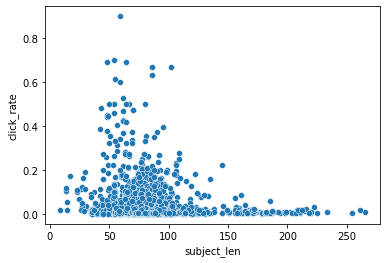

In [32]:
sns.scatterplot(y=target_column, x='subject_len', data = df)

### emails with body length greater than 30000 characters have very low click through rate

<AxesSubplot:xlabel='body_len', ylabel='click_rate'>

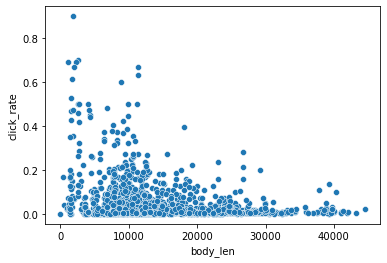

In [33]:
sns.scatterplot(y=target_column, x='body_len', data = df)

### emails with mean paragrpah length less than 100 have higher clickthrough rate. Also, as the number of characters increase significant decrease in CTR is observed.

<AxesSubplot:xlabel='mean_paragraph_len', ylabel='click_rate'>

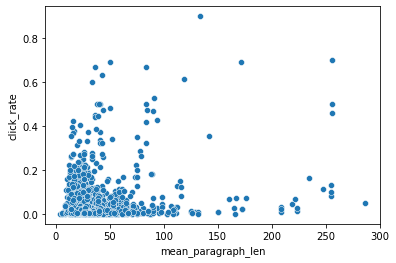

In [34]:
sns.scatterplot(y=target_column, x='mean_paragraph_len', data = df)

### emails with less than 10 CTA have higher clickthrough rate

<AxesSubplot:xlabel='no_of_CTA', ylabel='click_rate'>

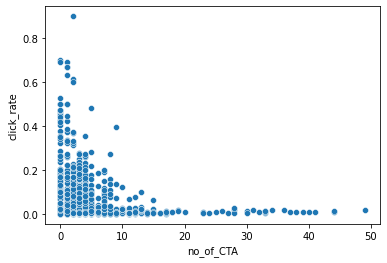

In [35]:
sns.scatterplot(y=target_column, x='no_of_CTA', data = df)

### emails with mean CTA length between have 10 t0 60 have higher click through rates

<AxesSubplot:xlabel='mean_CTA_len', ylabel='click_rate'>

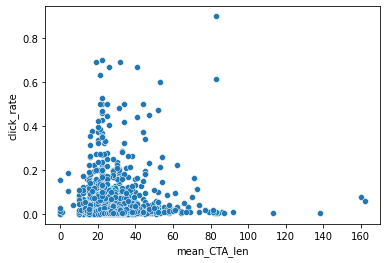

In [36]:
sns.scatterplot(y=target_column, x='mean_CTA_len', data = df)

## Target variable

### row with 0.90 click through rate is a outlier as the mean click through rate is 0.04 and max is 0.90 and 75% of rows have values less than or equal to 0.036. But in over case it is highest positive values. 

In [37]:
train[target_column].describe()

count    1888.000000
mean        0.041888
std         0.084223
min         0.000000
25%         0.005413
50%         0.010686
75%         0.035589
max         0.897959
Name: click_rate, dtype: float64

<AxesSubplot:xlabel='click_rate'>

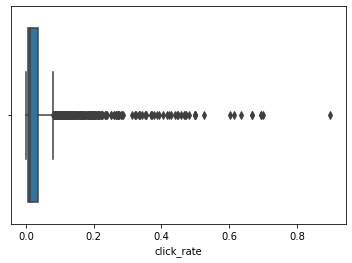

In [38]:
sns.boxplot(x = target_column, data = train)

#  Model selection and training

## Creating basemodels

In [71]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from lightgbm import LGBMRegressor as LGR
from xgboost import XGBRegressor as XGR
from pprint import pprint
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import r2_score

In [72]:
## make the model as per specifications
def make_model(xtr,ytr,model_type):
    if model_type == 'GBR':
        clf = GBR(random_state=42)
    elif model_type == 'RFR':
        clf = RFR(random_state=42)
    elif model_type == 'LR':
        clf = LR()
    elif model_type == 'XGBOOST':
        clf = XGR(random_state=42)
    elif model_type == 'LIGHTGBM':
        clf = LGR(random_state=42)
    
    clf.fit(xtr,ytr)
    return clf

In [73]:
def get_basemodels(X_train, X_test, y_train, y_test):
    
    models = ['LR','GBR','LIGHTGBM', 'RFR', 'XGBOOST']
    
    model_names = []
    trained_models = []
    r2_train_scores = []
    r2_test_scores = []
    ## iterate over model type and the dependent variable
    for model in models:
        clf = make_model(X_train, y_train, model)
        
        y_train_predictions = clf.predict(X_train)
        model_names.append(model)
        trained_models.append(clf)
        r2_train_scores.append(r2_score(y_train_predictions, y_train))
        
        y_test_predictions = clf.predict(X_test)
        r2_test_scores.append(r2_score(y_test_predictions, y_test ))
    ## collating results
    error_df = pd.DataFrame()
    error_df['model_type'] = model_names
    error_df['trained_models'] = trained_models
    error_df['train_r2_score'] = r2_train_scores
    error_df['test_r2_score'] = r2_test_scores
    
    return trained_models, error_df

In [95]:
X_train, X_test, y_train, y_test = train_test_split(df[category_features + continous_features], df[target_column],
                                            test_size=0.30, random_state=42)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_new_test_scaled = scaler.transform(df[category_features + continous_features])

In [96]:
models, r2_scores = get_basemodels(X_train_scaled, X_test_scaled, y_train, y_test)
r2_scores

,model_type,trained_models,train_r2_score,test_r2_score
0,LR,LinearRegression(),-4.401473,-2.471005
1,GBR,([DecisionTreeRegressor(criterion='friedman_ms...,0.541948,-0.006508
2,LIGHTGBM,LGBMRegressor(random_state=42),0.778091,0.387561
3,RFR,"(DecisionTreeRegressor(max_features='auto', ra...",0.892586,0.147418
4,XGBOOST,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.996701,0.358182


- XgBoost is performing the best with r2_score of 0.991
- Random forest is performing second best with r2_score of 0.911
- LightGBM is performing third best with r2_score of 0.755
- Linear regression and gradient boosting are performing ver bad.

Based on the above, we will pursue determination of important features and hyperparameter tuning for XgBoost, Random Forest and LightGBM

## Hyperparameter tuning for XGBOOST

In [76]:
xgb_regressor = XGR()

In [77]:
## Hyper Parameter Optimization
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree']
learning_rate=[0.05, 0.1, 0.15, 0.20]
min_child_weight=[1, 2, 3, 4]
base_score = [0.25, 0.5, 0.75, 1]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=xgb_regressor,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

random_cv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                                          predictor=None, random_state=None,
                             

In [78]:
random_cv.best_estimator_

XGBRegressor(base_score=0.25, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=2,
             missing=nan, monotone_constraints='()', n_estimators=1100,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [79]:
ytsp = random_cv.best_estimator_.predict(X_test_scaled)
r2_score(ytsp, y_test)

0.23366383331388718

## Hyperparameter tuning of random forest

In [80]:
n_estimators = [100, 500, 900, 1100, 1500]
max_features = ['auto', 'sqrt']
max_depth = [2, 3, 5, 10, 15]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [2, 3, 5, 10, 15, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 500, 900, 1100, 1500]}


In [100]:
rf = RFR()
rf_random = RandomizedSearchCV(estimator = rf,
           param_distributions = random_grid,
           n_iter = 100, cv = 5,
           verbose=2, 
           random_state=42, n_jobs = -1)
rf_random.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 3, 5, 10, 15, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500]},
                   random_state=42, verbose=2)

In [101]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt')

In [102]:
rf_best = RFR(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=5, n_estimators=1500)

In [103]:
y_pred_rfr = rf_random.best_estimator_.predict(X_test_scaled)
r2_score(y_pred_rfr, y_test)

0.3970454898411181

## lightGBM hyperparameter tuning

## ANN

In [ ]:
impoort keras
from keras.models import Sequential 
from keras.layers import dense
from keras.layers import LeakyReLU, PReLU, ELU
from keras.layers import Dropout

regressor = Sequential()

regressor.add(Dense(output_dum))

## Getting important features from base models

In [ ]:
def model_important_features(models):
    fig = plt.figure(figsize=(14, 4))

    #  subplot #1
    plt.subplot(131)
    plt.title('XgBoost feature importance')
    final_df = pd.DataFrame()
    final_df['Features'] = category_features + continous_features
    final_df['Importance'] = models[-1].feature_importances_.tolist()
    final_df.sort_values(by=['Importance'], inplace=True, ascending=False)
    sns.barplot(y='Features', x='Importance', data=final_df, orient="h")

    #  subplot #2
    plt.subplot(132)
    plt.title('Random forest feature importance')
    final_df1 = pd.DataFrame()
    final_df1['Features'] = category_features + continous_features
    final_df1['Importance'] = models[-2].feature_importances_.tolist()
    final_df1.sort_values(by=['Importance'], inplace=True, ascending=False)
    sns.barplot(y='Features', x='Importance', data=final_df1, orient="h")
    
    plt.subplot(133)
    plt.title('LightGBM feature importance')
    final_df2 = pd.DataFrame()
    final_df2['Features'] = category_features + continous_features
    final_df2['Importance'] = models[-3].feature_importances_.tolist()
    final_df2.sort_values(by=['Importance'], inplace=True, ascending=False)
    sns.barplot(y='Features', x='Importance', data=final_df2, orient="h")

    plt.tight_layout()
    plt.show()

In [ ]:
model_important_features(models)

## Getting predictions from base model

In [99]:
len(X_new_test_scaled)

1888

In [97]:
def get_predictions(best_model):
    predictions = pd.read_csv('sample_submission.csv')
    predictions['click_rate'] = best_model.predict(X_new_test_scaled)
    predictions.to_csv('2022 08 07 submission_v1.csv', index=False)
    return predictions

In [98]:
predictions = get_predictions(rf_random.best_estimator_)
predictions

ValueError: Length of values (1888) does not match length of index (762)